# Computing the Lagrangian Descriptors of Nonlinear Dynamical Systems

## Basic setup: IMPORTANT

BEFORE running this Notebook we assume the following 

* This notebook runs with Python Version `>= 3`

* `conda` si up-to-date. If not, in the terminal (Linux/Mac) or the `Conda Prompt` (Windows)

```bash
conda update --all
```

If you're running this notebook and it works fine. That's good news!

If you get error, please, try the proposed instructions in the next Subsection. 

## Package requirements

* DO RUN the following lines, only if the current Notebook doesn't execute properly.
* DON'T RUN the following lines, if `requirements.txt` already satisfied or if Notebook runs fine. 

If `pip` not installed within `conda` environment, execute the cell below

```bash
conda install pip==20.0.2
```

Install _package dependencies_

```bash
pip install -r requeriments.txt
```

## Benchmark examples

In [1]:
import pylds
from pylds.base import compute_lagrangian_descriptor, perturb_field
from pylds.tools import draw_lagrangian_descriptor
from pylds.vector_fields import HamCenter1D, HamSaddle1D, Duffing1D, HamSN1D, Duffing1D_inverted, forcing, HenonHeiles_potential, HenonHeiles_vector_field, NFSaddle_potential, NFSaddle_vector_field

In [2]:
# Integration parameters
tau = 12

# LDp, p-value
p_value = 0.5

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

### Some simple systems

#### Hamilton Centre

_Energy_

\begin{equation*}
H(x, y) = \frac{\omega}{2} (y^2 + x^2), \quad \omega > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial y} = f_1(x, y) = \omega y \\
 \dot{y} &= \frac{\partial H}{\partial x} = f_2(x, y) = -\omega x
 \end{align*}

In [3]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamCenter1D

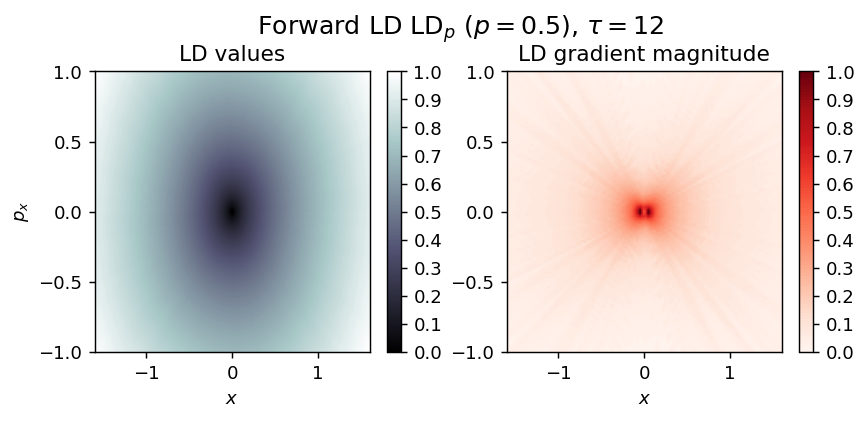

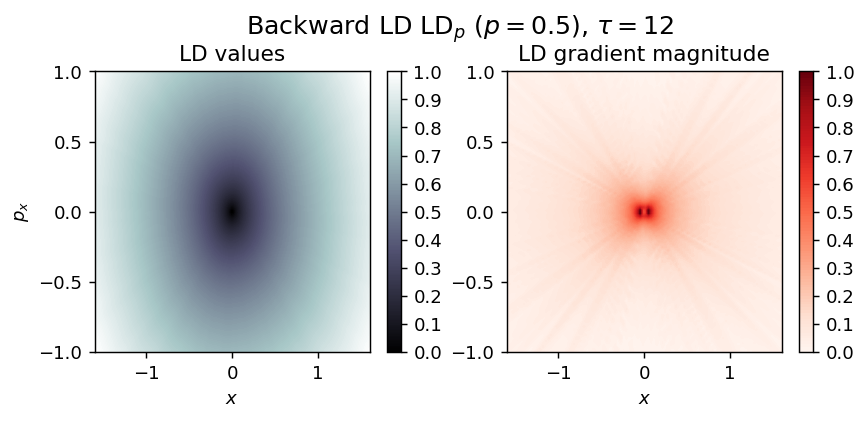

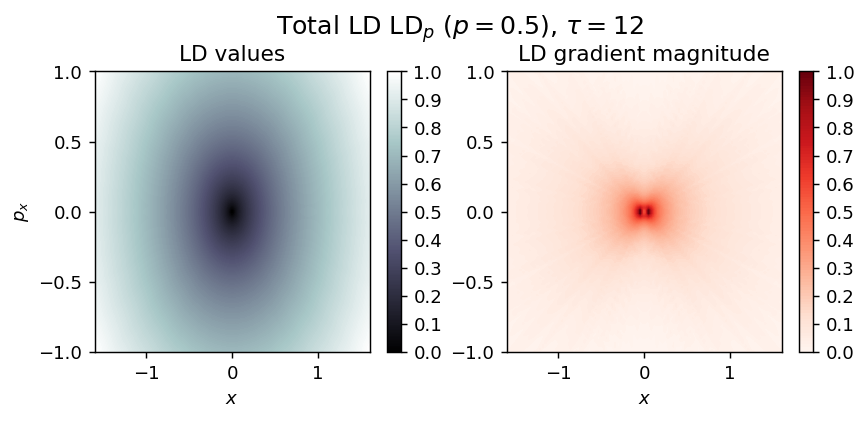

In [4]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Hamilton Saddle

_Energy_

\begin{equation*}
H(x, y) = \frac{\lambda}{2}( y^2 -  x^2 ), \quad \lambda > 0
\end{equation*}

_Vector field_

\begin{align*}
 \dot{x} &= \frac{\partial H}{\partial y} = f_1(x, y) = -\lambda y \\
 \dot{y} &= \frac{\partial H}{\partial x} = f_2(x, y) = \lambda x
 \end{align*}

In [5]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSaddle1D

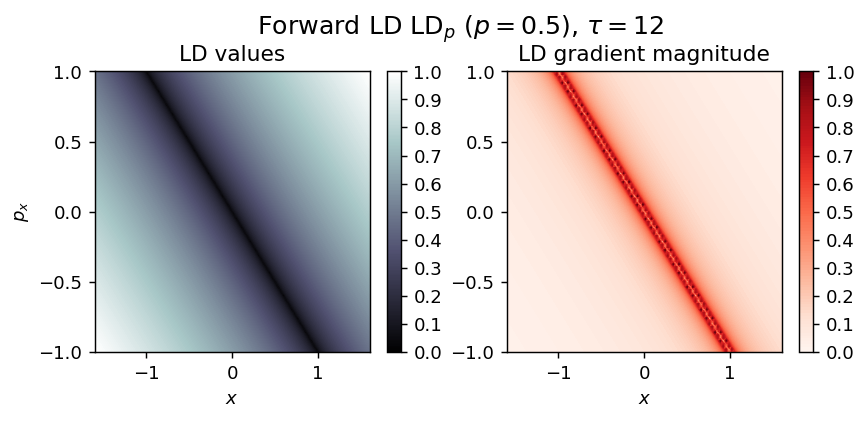

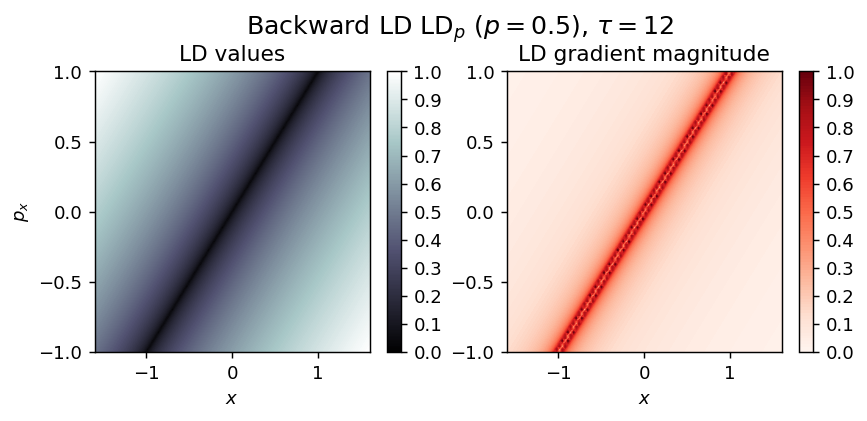

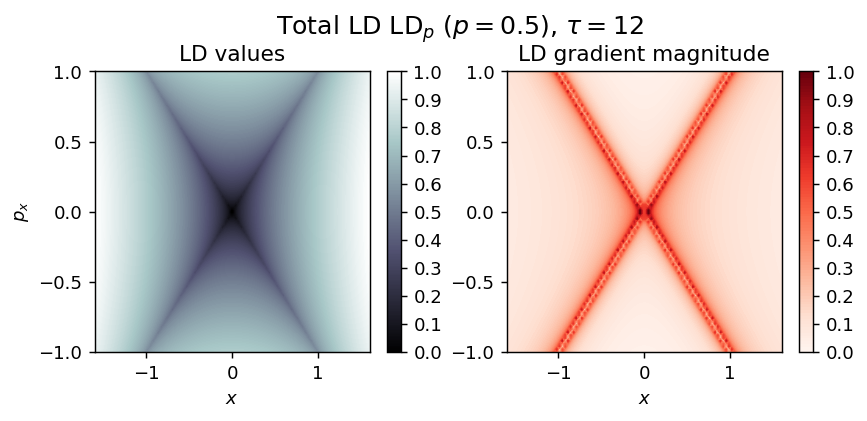

In [6]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Duffing oscillator

In [7]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = Duffing1D

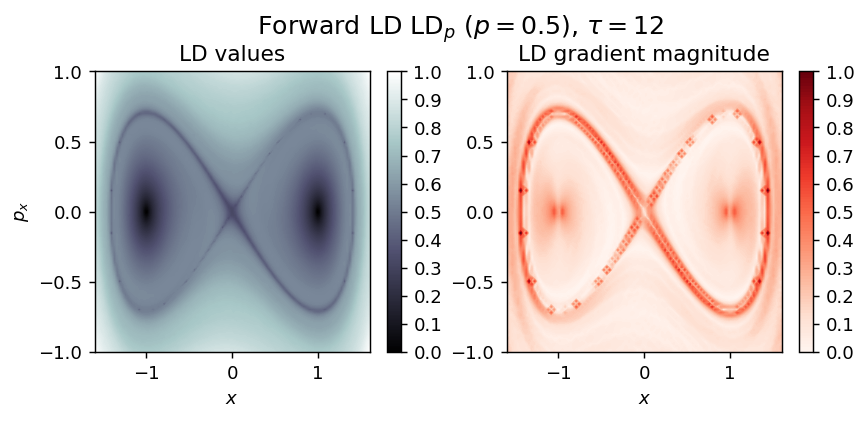

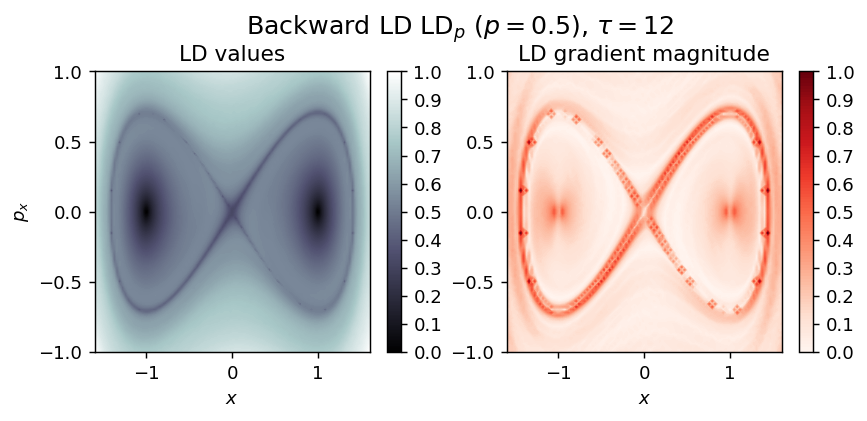

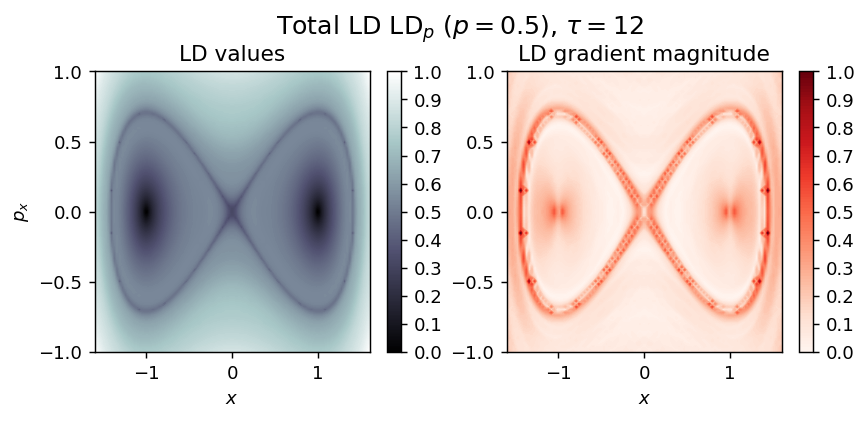

In [8]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

### Example of a perturbed system

#### Harmonically perturbed Duffing oscillator

In [39]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field_original = Duffing1D
vector_field = perturb_field(vector_field_original, forcing)

In [42]:
%matplotlib widget
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value, interactive=True)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value, interactive=True)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value, interactive=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='grad_minimum', max=1.0), Output()), _dom_classes=('w…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='grad_minimum', max=1.0), Output()), _dom_classes=('w…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='grad_minimum', max=1.0), Output()), _dom_classes=('w…

### Example of systems that blow up in finite time

#### Hamilton Saddle-Node

In [11]:
###################################
# Integration parameters
t0 = 0
tau = 8
dt = 0.1

# Lp-norm, p-value
p_norm = 1/2
###################################
# Mesh parameters
x_min,x_max = [-1.5, 1]
y_min,y_max = [-1, 1]
###################################
# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]

In [12]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = HamSN1D
box_boundaries = [(box_x_min, box_x_max)]

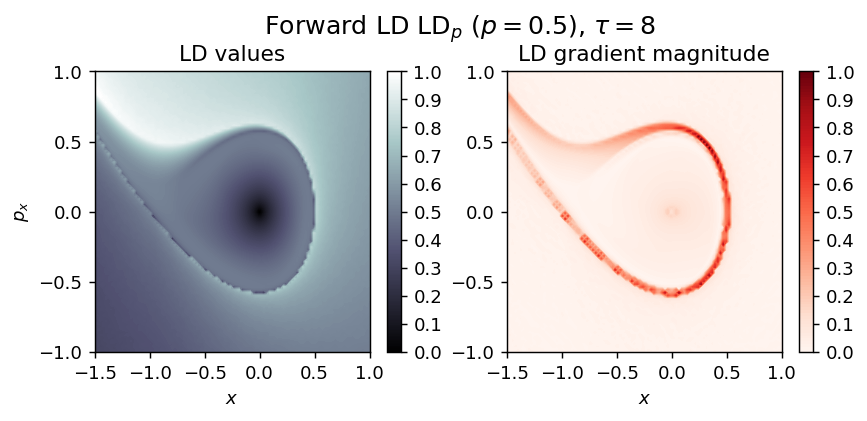

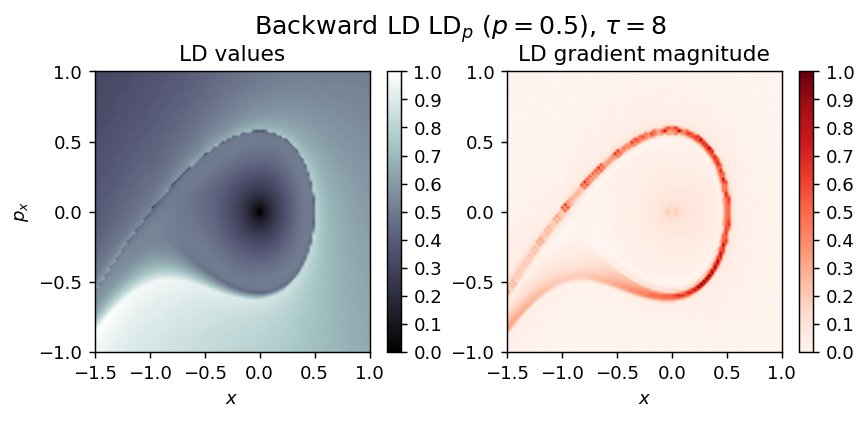

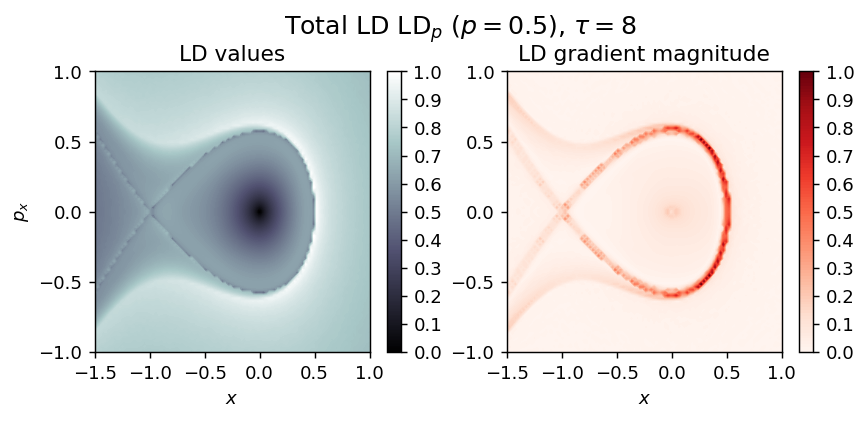

In [13]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Inverted Duffing oscillator

In [14]:
###################################
# Integration parameters
t0 = 0
tau = 10
dt = 0.1

# Lp-norm, p-value
p_norm = 1/2
###################################
# Mesh parameters
x_min,x_max = [-1.5, 1.5]
y_min,y_max = [-1, 1]
###################################
# Box boundaries for Variable Time Integration
box_x_min, box_x_max = [-6, 6]

In [15]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)]
vector_field = Duffing1D_inverted
box_boundaries = [(box_x_min, box_x_max)]

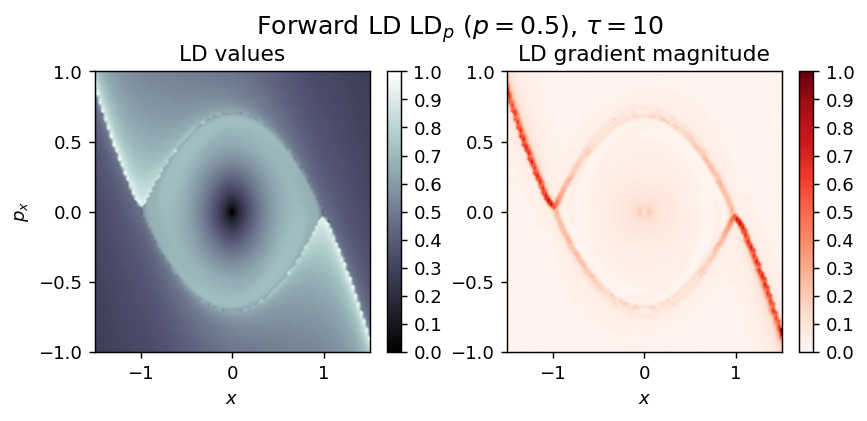

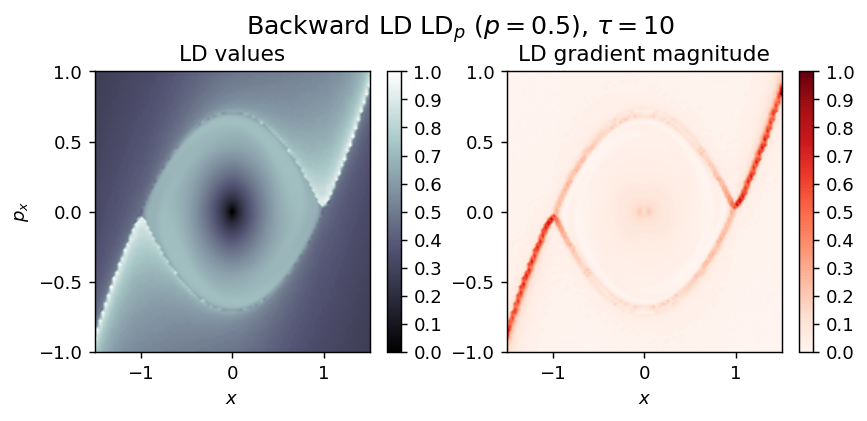

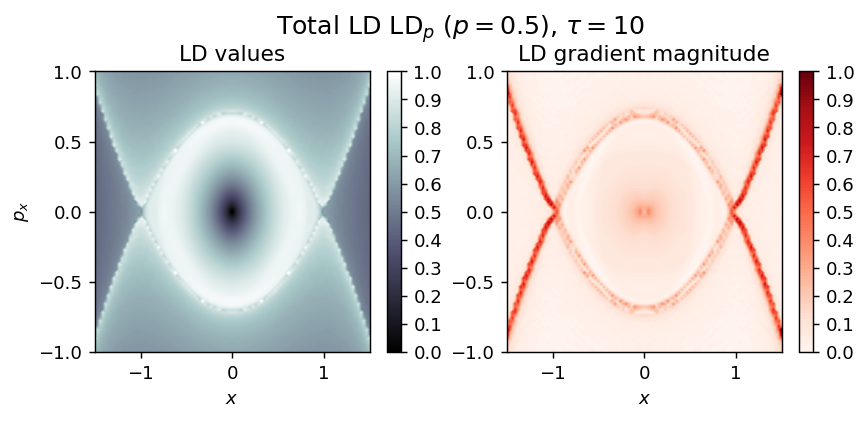

In [16]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

### High-dimensional Hamiltonian systems

#### Henon-Heiles

In [17]:
# Integration parameters
t0 = 0
tau = 50

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1/5 # Energy

ax1_min,ax1_max = [-0.6, 1.2]
ax2_min,ax2_max = [-0.65, 0.65]
N1, N2 = [100, 100]

# Box escape condition
box_boundaries = [[-5, 5], [-5, 5]]

# Miscellaneous grid parameters
dims_fixed = [1,0,0,0] # Variable ordering (x1 x2 y1 y2)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [0,1,0,1] # Visualisation slice
momentum_sign = 1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [18]:
potential_energy = HenonHeiles_potential
vector_field = HenonHeiles_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

/home/vk17590/LD/LD book examples/lds-develop/pylds/base.py:22: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(2*(H0 - V) - (phase_space_momenta**2).sum(axis=1))


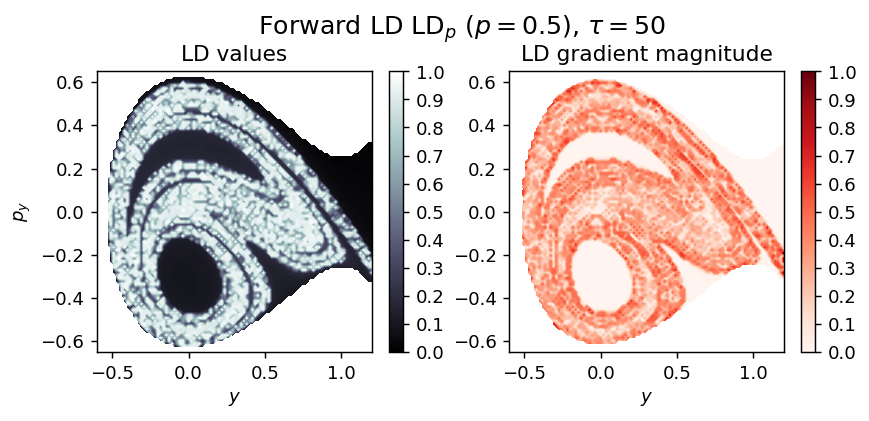

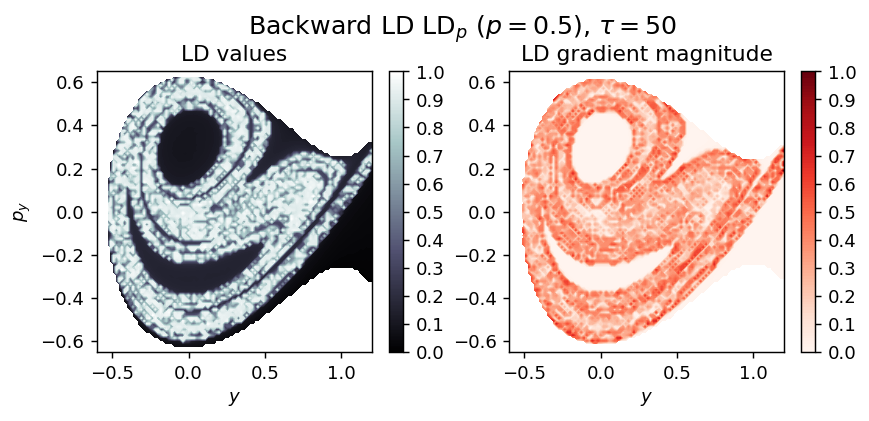

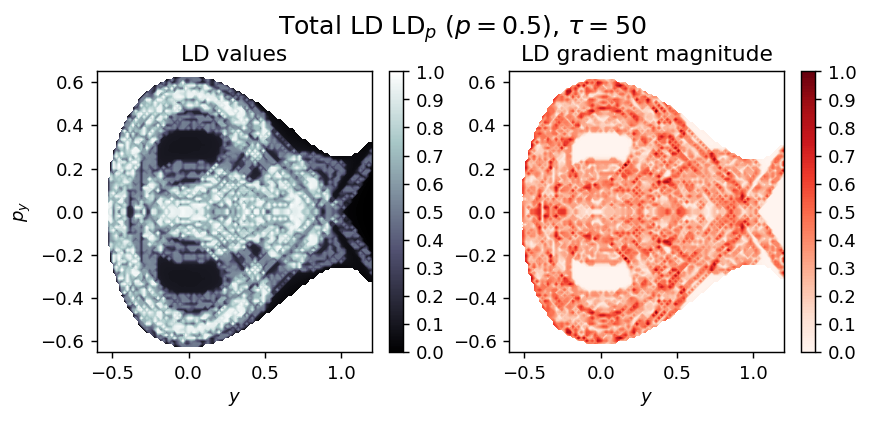

In [19]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value, box_boundaries)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Index-1 Normal Form Saddle

In [20]:
# Integration parameters
t0 = 0
tau = 10

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1 # Energy
ax1_min,ax1_max = [-2, 2]
ax2_min,ax2_max = [-2, 2]
N1, N2 = [100, 100]

# Box escape condition
box_boundaries = False

# Miscellaneous grid parameters
dims_fixed = [0,1,0,0] # Variable ordering (x1 x2 y1 y2)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [1,0,1,0] # Visualisation slice
momentum_sign = -1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [21]:
potential_energy = NFSaddle_potential
vector_field = NFSaddle_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

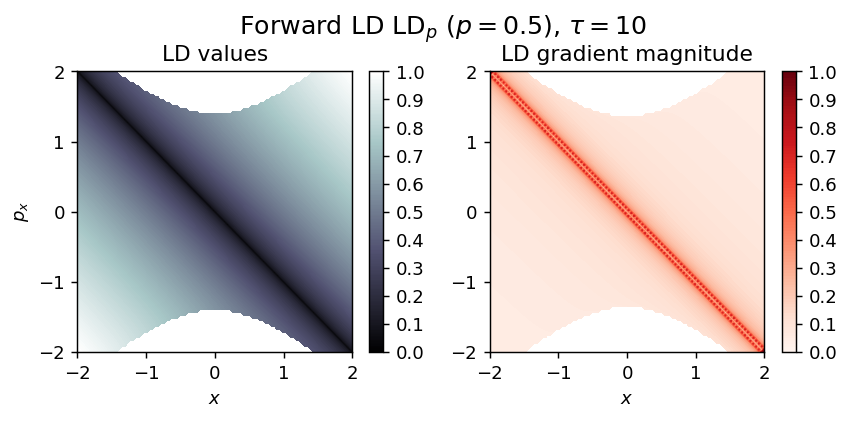

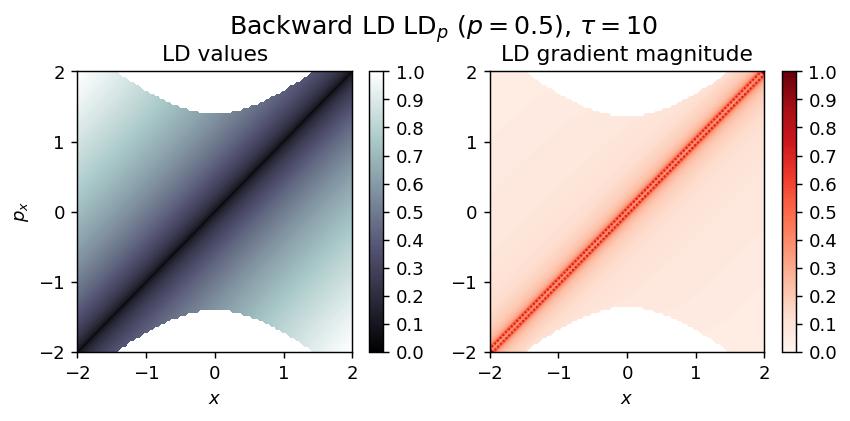

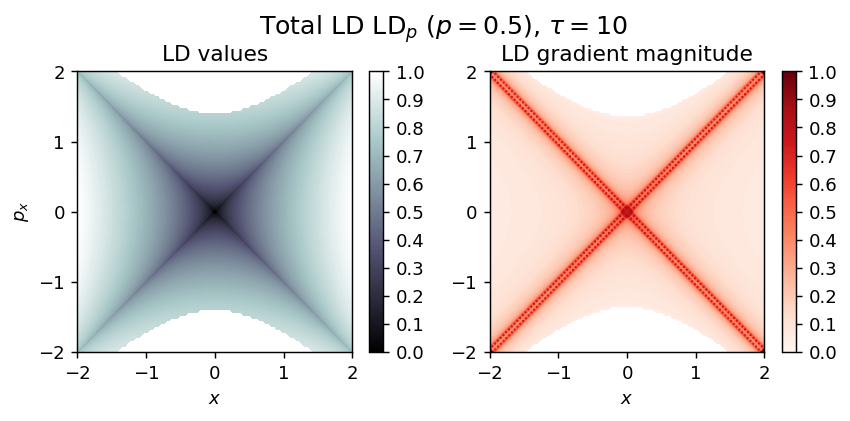

In [22]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

#### Double well potential

In [23]:
import numpy as np

In [24]:
def DoubleWell2DoF_vector_field(t, u, PARAMETERS = [None]):
    """
    Returns 1D vector field of the Duffing oscillator, for an array of points in phase space.
    Number of model parameters: 0 . PARAMETERS = [None]
    Functional form: v = (y, x - x**3), with u = (x, y)
    
    Parameters
    ----------  
    t : float
        fixed time-point of vector field, for all points in phase space.
        
    u : array_like, shape(n,)
        Points in phase space.
        
    PARAMETERS : list of floats
        Vector field parameters.
    
    Returns
    -------
    v : array_like, shape(n,)
        Vector field corresponding to points u, in phase space at time t.
    """
    N_dims = u.shape[-1]
    points_positions = u.T[:int(N_dims/2)]
    points_momenta = u.T[int(N_dims/2):]
    x, y = points_positions
    p_x, p_y = points_momenta 
    
    # Hamiltonian Model Parameter
    
    # Vector field defintion
    v_x   =  p_x
    v_y   =  p_y
    v_p_x =  x - x**3
    v_p_y = -y
    v = np.array([v_x, v_y, v_p_x, v_p_y]).T
    return v

In [25]:
def DoubleWell2DoF_potential(positions, PARAMETERS = None):
    x, y = positions.T
    # Function parameters
    # None
    # Potential energy function
    V = (1/4)*x**4 - (1/2)*x**2 + (1/2)*y**2
    return V

In [26]:
# Integration parameters
t0 = 0
tau = 10

# Lp-norm, p-value
p_value = 1/2

# Mesh visualisation slice parameters
H0 = 1 # Energy
ax1_min,ax1_max = [-2, 2]
ax2_min,ax2_max = [-2, 2]
N1, N2 = [200, 200]

# Box escape condition
box_boundaries = False

# Miscellaneous grid parameters
dims_fixed = [0,1,0,0] # Variable ordering (x y p_x p_y)
dims_fixed_values = [0] # This can also be an array of values
dims_slice = [1,0,1,0] # Visualisation slice
momentum_sign = 1 # Direction of momentum that defines the slice - (1) positive / (-1) negative

In [27]:
potential_energy = DoubleWell2DoF_potential
vector_field = DoubleWell2DoF_vector_field

slice_parameters = [[ax1_min, ax1_max, N1],[ax2_min, ax2_max, N2]]

grid_parameters = {
        'slice_parameters' : slice_parameters,
        'dims_slice' : dims_slice,
        'dims_fixed' : [dims_fixed, dims_fixed_values],
        'momentum_sign' : momentum_sign,
        'potential_energy': potential_energy,
        'energy_level': H0
    }

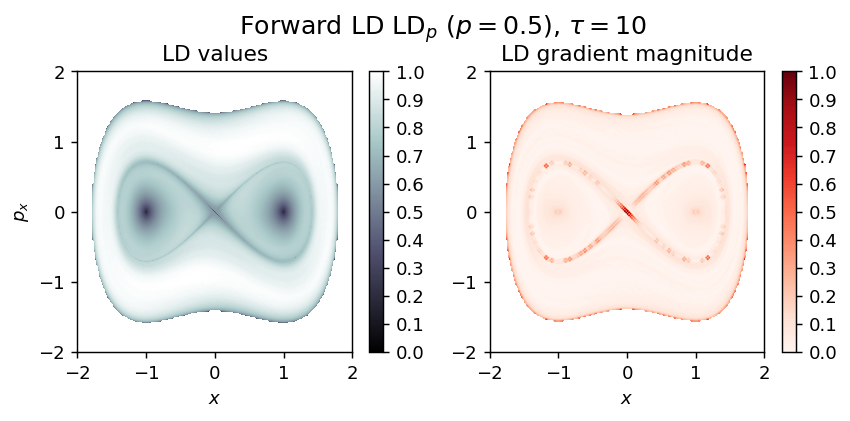

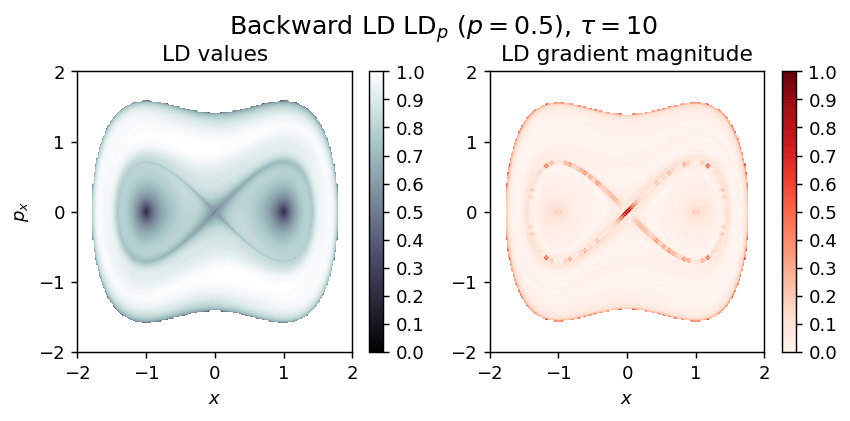

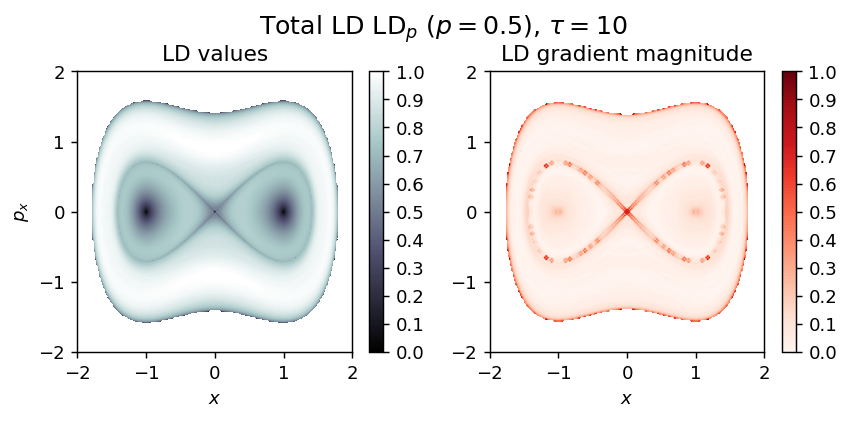

In [28]:
LD_forward = compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value)

LD_backward = compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, tau, p_value)

LD_total = LD_forward + LD_backward
draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value)

## HOW-TOs

### Change parameters of built-in vector fields

<span style='color:blue'><b>FIRST</b></span> Check vector field parameters using `help`

In [29]:
import pylds
help(pylds.vector_fields.HamCenter1D)

Help on function HamCenter1D in module pylds.vector_fields:

HamCenter1D(t, u, PARAMETERS=[1])
    Returns 1D Hamilton-Centre vector field at time t, for an array of points in phase space.
    Number of model parameters: 1 . PARAMETERS = [omega]
    Functional form: v = (omega*y, - omega*x), with u = (x, y)
    
    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase space
        
    u : array_like, shape(n,)
        points in phase space to determine vector field at time t
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase space at time t



<span style='color:blue'><b>SECOND</b></span> Define the input `vector_field` to compute LDs, just editing the value of `PARAMETERS`, here we set `omega = 2.5`

In [30]:
import pylds
vector_field = lambda t,u : pylds.vector_fields.HamCenter1D(t, u, PARAMETERS=[2.5])

### Working with my own vector field

Setting up the code to draw the LDs of your own function requires only _THREE_ simple steps

_EXAMPLE_

Suppose we have a 2D vector field of the form

\begin{align*}
f_1(x, y) &= \alpha y \\
f_2(x, y) &= \beta \cdot cos(\gamma x^3)
\end{align*}

<span style='color:blue'><b>FIRST</b></span> Define `my_vector_field` function

See how it's done below

In [31]:
import numpy as np

def my_vector_field(t, u, PARAMETERS = [2, 0.5, 3]):
    """
    Returns 1D Hamilton-Saddle vector field at time t, for an array of points in phase-space.
    Number of model parameters: 1 . PARAMETERS = [alpha, beta, gamma]
    Functional form: v = (alpha*y, beta*x + gamma*x**4), with u = (x, y)
    
    Parameters
    ----------
    t : float
        fixed time-point of vector field, for all points in phase-space.
        
    u : array_like, shape(n,)
        points in phase-space to determine vector field at common time t.
    
    PARAMETERS : list of floats
        vector field parameters
    
    Returns
    -------
    v : array_like, shape(n,)
        vector field corresponding to points u, in phase-space at time t
    """
    x, y = u.T
    ##############################################
    #
    # CHANGE THIS STUFF BELOW ONLY
    #
    ##############################################
    # Hamiltonian Model Parameter
    alpha, beta, gamma = PARAMETERS
    v = np.array([ alpha * y, beta * np.cos(gamma * x**3)]).T
    ##############################################
    #
    # CHANGE THIS STUFF ABOVE ONLY
    #
    ##############################################    
    return v

Then, the input `vector_field` for computation of LDs will be

In [32]:
vector_field = my_vector_field

<span style='color:blue'><b>SECOND</b></span> Set your general input parameters

In [33]:
import pylds

# Integration parameters
t0 = 0 # Starting time for integration
tau = 8 # Length integration
dt = 0.1 # Timestep

# Lp-norm, p-value
p_value = 1/2

# Mesh parameters
x_min,x_max = [-1.6, 1.6]
y_min,y_max = [-1, 1]
Nx, Ny = [100, 100]

In [34]:
grid_parameters = [(x_min, x_max, Nx), (y_min, y_max, Ny)] # Grid to sample Initial Conditions

<span style='color:blue'><b>THIRD</b></span> Compute and Visualise your desired Lagrangian Descriptors

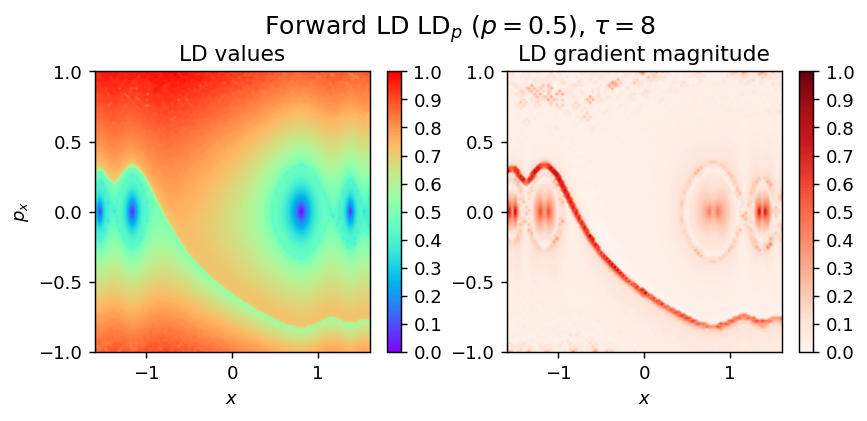

In [35]:
LD_forward = pylds.base.compute_lagrangian_descriptor(grid_parameters, vector_field, tau, p_value)
pylds.tools.draw_lagrangian_descriptor(LD_forward, 'forward', grid_parameters, tau, p_value, colormap_name='rainbow')

__Note__ The only difference for `LD_backward` is the integration time `- tau`

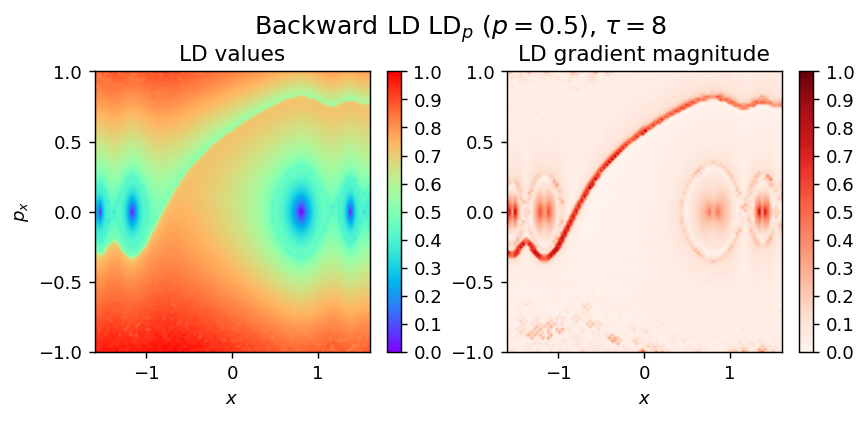

In [36]:
LD_backward = pylds.base.compute_lagrangian_descriptor(grid_parameters, vector_field, -tau, p_value)
pylds.tools.draw_lagrangian_descriptor(LD_backward, 'backward', grid_parameters, -tau, p_value, colormap_name='rainbow')

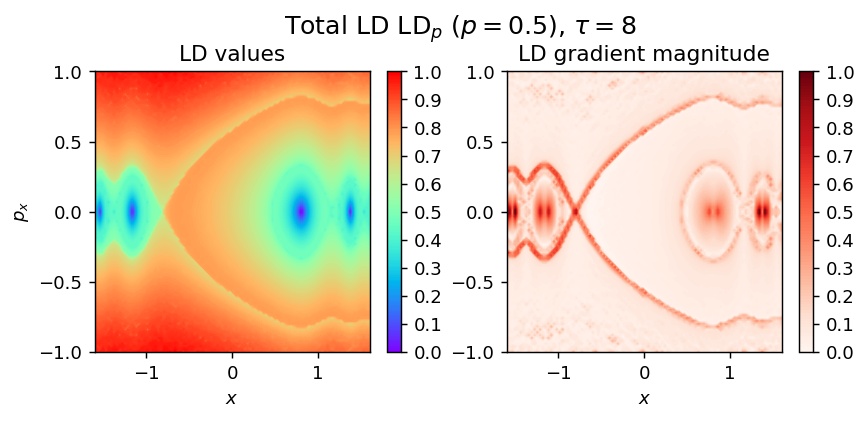

In [37]:
LD_total = LD_forward + LD_backward
pylds.tools.draw_lagrangian_descriptor(LD_total, 'total', grid_parameters, tau, p_value, colormap_name='rainbow')